# Preprocessing of datasets

Attack traffic datasets (Booters) from https://ieeexplore.ieee.org/document/7140298/

Benign traffic datasets from http://mawi.wide.ad.jp/mawi/

In [ ]:
import pandas as pd
from collections import Counter
import hashlib
import random
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt

In [ ]:
# load datasets
df = []
df.append(pd.read_csv('anon-Booter_dns1.pcap.csv'))
df.append(pd.read_csv('anon-Booter_dns2.pcap.csv'))
df.append(pd.read_csv('anon-Booter_dns3.pcap.csv'))
df.append(pd.read_csv('anon-Booter_dns4.pcap.csv'))
df.append(pd.read_csv('anon-Booter_dns5.pcap.csv'))
df.append(pd.read_csv('anon-Booter_dns6.pcap.csv'))
df.append(pd.read_csv('anon-Booter_dns7.pcap.csv'))
df.append(pd.read_csv('wideg_dns_cleared.csv'))
df.append(pd.read_csv('widef_dns_cleared.csv'))

Show first samples of datasets. The 7 *booter* datasets have the same structure, as well as the 2 *wide* datasets.

In [ ]:
df[0].head()

,frame.time_relative,ip.len,ip.src,ip.dst,udp.length,dns.id,dns.flags.response,dns.flags.opcode,dns.flags.authoritative,dns.flags.truncated,dns.flags.recdesired,dns.flags.recavail,dns.flags.z,dns.flags.authenticated,dns.flags.checkdisable,dns.flags.rcode,dns.count.queries,dns.count.answers,dns.count.auth_rr,dns.count.add_rr,dns.qry.name,dns.qry.type,dns.qry.class
0,0.000000,1054,107.87.219.23,227.213.154.241,1034,0x0000c03b,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,14.0,13.0,23.0,<Root>,255.0,0x00000001
1,0.000085,1054,107.87.219.23,227.213.154.241,1034,0x0000c03b,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,14.0,13.0,23.0,<Root>,255.0,0x00000001
2,0.000172,1054,107.87.219.23,227.213.154.241,1034,0x0000c03b,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,14.0,13.0,23.0,<Root>,255.0,0x00000001
3,0.000259,1054,107.87.219.23,227.213.154.241,1034,0x0000c03b,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,14.0,13.0,23.0,<Root>,255.0,0x00000001
4,0.000347,1054,107.87.219.23,227.213.154.241,1034,0x0000c03b,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,14.0,13.0,23.0,<Root>,255.0,0x00000001


In [ ]:
df[7].head()

,ip.len,ip.src,ip.dst,udp.length,dns.flags.response,dns.flags.opcode,dns.flags.authoritative,dns.flags.truncated,dns.flags.recdesired,dns.flags.recavail,dns.flags.authenticated,dns.flags.checkdisable,dns.count.queries,dns.count.answers,dns.count.auth_rr,dns.count.add_rr,dns.qry.name,dns.qry.type,dst_AS,src_AS
0,87.0,210.166.249.129,133.91.254.11,67.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,wa3.i-3-i.info,1.0,23623,7514
1,286.0,8.8.8.8,150.65.3.6,266.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,13.0,0.0,1.0,cnc.hub5pn.sandai.net,1.0,17932,15169
2,135.0,8.8.8.8,203.178.130.217,115.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,7.3.215.95.in-addr.arpa,12.0,2500,15169
3,208.0,8.8.8.8,150.65.3.6,188.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,8.0,0.0,1.0,cncidx.m.hub.sandai.net,1.0,17932,15169
4,232.0,203.178.141.194,157.7.180.137,212.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,5.0,orange.kame.net,1.0,7506,2500


At first, delete columns that do not exist in both datasets and, if needed, reorder the rest columns of one dataset to match the order of the other. For now, keep the *dst_AS* column of the *wide* datasets, because it will help distribute samples to clients. Also, drop *ip.src* and *ip.dst*, because they are too specific and do not really contribute to distinguishing attack and benign traffic in general case.

In [ ]:
for i in range(0, 7):
    df[i].drop(columns=['ip.src', 'ip.dst', 'frame.time_relative', 'dns.id', 'dns.flags.z', 'dns.flags.rcode', 'dns.qry.class'], inplace=True)
df[0].head()

,ip.len,udp.length,dns.flags.response,dns.flags.opcode,dns.flags.authoritative,dns.flags.truncated,dns.flags.recdesired,dns.flags.recavail,dns.flags.authenticated,dns.flags.checkdisable,dns.count.queries,dns.count.answers,dns.count.auth_rr,dns.count.add_rr,dns.qry.name,dns.qry.type
0,1054,1034,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,14.0,13.0,23.0,<Root>,255.0
1,1054,1034,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,14.0,13.0,23.0,<Root>,255.0
2,1054,1034,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,14.0,13.0,23.0,<Root>,255.0
3,1054,1034,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,14.0,13.0,23.0,<Root>,255.0
4,1054,1034,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,14.0,13.0,23.0,<Root>,255.0


In [ ]:
for i in range(7, 9):
    df[i].drop(columns=['ip.src', 'ip.dst', 'src_AS'], inplace=True)
df[7].head()

,ip.len,udp.length,dns.flags.response,dns.flags.opcode,dns.flags.authoritative,dns.flags.truncated,dns.flags.recdesired,dns.flags.recavail,dns.flags.authenticated,dns.flags.checkdisable,dns.count.queries,dns.count.answers,dns.count.auth_rr,dns.count.add_rr,dns.qry.name,dns.qry.type,dst_AS
0,87.0,67.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,wa3.i-3-i.info,1.0,23623
1,286.0,266.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,13.0,0.0,1.0,cnc.hub5pn.sandai.net,1.0,17932
2,135.0,115.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,7.3.215.95.in-addr.arpa,12.0,2500
3,208.0,188.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,8.0,0.0,1.0,cncidx.m.hub.sandai.net,1.0,17932
4,232.0,212.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,5.0,orange.kame.net,1.0,7506


Drop samples with missing values.

In [ ]:
for i in range(0, 9):
    df[i].dropna(axis=0, inplace=True)

Add a column for the target, i.e. 0 for benign traffic and 1 for attack traffic.

In [ ]:
for i in range(0, 7):
    df[i] = df[i].assign(target = [1.0 for j in range(len(df[i]))])
df[0].head()

,ip.len,udp.length,dns.flags.response,dns.flags.opcode,dns.flags.authoritative,dns.flags.truncated,dns.flags.recdesired,dns.flags.recavail,dns.flags.authenticated,dns.flags.checkdisable,dns.count.queries,dns.count.answers,dns.count.auth_rr,dns.count.add_rr,dns.qry.name,dns.qry.type,target
0,1054,1034,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,14.0,13.0,23.0,<Root>,255.0,1.0
1,1054,1034,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,14.0,13.0,23.0,<Root>,255.0,1.0
2,1054,1034,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,14.0,13.0,23.0,<Root>,255.0,1.0
3,1054,1034,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,14.0,13.0,23.0,<Root>,255.0,1.0
4,1054,1034,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,14.0,13.0,23.0,<Root>,255.0,1.0


In [ ]:
for i in range(7, 9):
    df[i] = df[i].assign(target = [0.0 for j in range(len(df[i]))])
df[7].head()

,ip.len,udp.length,dns.flags.response,dns.flags.opcode,dns.flags.authoritative,dns.flags.truncated,dns.flags.recdesired,dns.flags.recavail,dns.flags.authenticated,dns.flags.checkdisable,dns.count.queries,dns.count.answers,dns.count.auth_rr,dns.count.add_rr,dns.qry.name,dns.qry.type,dst_AS,target
0,87.0,67.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,wa3.i-3-i.info,1.0,23623,0.0
1,286.0,266.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,13.0,0.0,1.0,cnc.hub5pn.sandai.net,1.0,17932,0.0
2,135.0,115.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,7.3.215.95.in-addr.arpa,12.0,2500,0.0
3,208.0,188.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,8.0,0.0,1.0,cncidx.m.hub.sandai.net,1.0,17932,0.0
4,232.0,212.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,5.0,orange.kame.net,1.0,7506,0.0


Notice that *dns.qry.name* and *dns.qry.type* are nominal categorical features. Transform the former to a numerical value via hashing. As far as the latter is concerned, one-hot encoding could be used, but that would add 255 columns to the dataset. A more efficient solution would be binary encoding. However, when trying to fit such an encoder in the concatenation of *dns.qry.type* columns of all datasets, memory issues occur (RAM gets exhausted). Another choice is to leave the feature as it is.

**Note:** Representing the values of a nominal feature as numbers is theoretically wrong in machine learning, because some order among these values is supposed, without such existing. However, due to the fact that some names or types appear in high frequence in one kind of traffic (e.g. DNS root zone name and DNS ANY type query in attack traffic), and after testing in practice, it was found that this representation tends to improve the results of the classifier, compared to dropping the aforementioned columns.

In [ ]:
for i in range(0, 9):
    df[i]['dns.qry.name'] = df[i]['dns.qry.name'].apply(lambda a: int(hashlib.sha256(a.encode('utf-8')).hexdigest(), 16) % 10**8)
df[7].head()

,ip.len,udp.length,dns.flags.response,dns.flags.opcode,dns.flags.authoritative,dns.flags.truncated,dns.flags.recdesired,dns.flags.recavail,dns.flags.authenticated,dns.flags.checkdisable,dns.count.queries,dns.count.answers,dns.count.auth_rr,dns.count.add_rr,dns.qry.name,dns.qry.type,dst_AS,target
0,87.0,67.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,70141173,1.0,23623,0.0
1,286.0,266.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,13.0,0.0,1.0,60770939,1.0,17932,0.0
2,135.0,115.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,91479927,12.0,2500,0.0
3,208.0,188.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,8.0,0.0,1.0,34701380,1.0,17932,0.0
4,232.0,212.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,5.0,28816654,1.0,7506,0.0


Convert to float numbers.

In [ ]:
for i in range(0, 7):
    df[i] = df[i].astype('float32')
df[0].head()

,ip.len,udp.length,dns.flags.response,dns.flags.opcode,dns.flags.authoritative,dns.flags.truncated,dns.flags.recdesired,dns.flags.recavail,dns.flags.authenticated,dns.flags.checkdisable,dns.count.queries,dns.count.answers,dns.count.auth_rr,dns.count.add_rr,dns.qry.name,dns.qry.type,target
0,1054.0,1034.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,14.0,13.0,23.0,61960000.0,255.0,1.0
1,1054.0,1034.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,14.0,13.0,23.0,61960000.0,255.0,1.0
2,1054.0,1034.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,14.0,13.0,23.0,61960000.0,255.0,1.0
3,1054.0,1034.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,14.0,13.0,23.0,61960000.0,255.0,1.0
4,1054.0,1034.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,14.0,13.0,23.0,61960000.0,255.0,1.0


In [ ]:
for i in range(7, 9):
    df[i].iloc[:,:-2] = df[i].iloc[:,:-2].astype('float32')
df[7].head()

,ip.len,udp.length,dns.flags.response,dns.flags.opcode,dns.flags.authoritative,dns.flags.truncated,dns.flags.recdesired,dns.flags.recavail,dns.flags.authenticated,dns.flags.checkdisable,dns.count.queries,dns.count.answers,dns.count.auth_rr,dns.count.add_rr,dns.qry.name,dns.qry.type,dst_AS,target
0,87.0,67.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,70141176.0,1.0,23623,0.0
1,286.0,266.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,13.0,0.0,1.0,60770940.0,1.0,17932,0.0
2,135.0,115.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,91479928.0,12.0,2500,0.0
3,208.0,188.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,8.0,0.0,1.0,34701380.0,1.0,17932,0.0
4,232.0,212.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,5.0,28816654.0,1.0,7506,0.0


Make a relatively balanced test set with samples from all datasets.

In [ ]:
# shuffle datasets
for i in range(0, 9):
    df[i] = df[i].sample(frac=1)

# add benign traffic to test set
testset = pd.concat([df[7].iloc[:100000,:], df[8].iloc[:80000,:]])
# remove selected samples from train set
df[7] = df[7].iloc[100000:,:]
df[8] = df[8].iloc[80000:,:]
# remove dst_AS column
testset.drop(columns=['dst_AS'], inplace=True)

# add attack traffic to test set
for i in range(0, 7):
    testset = pd.concat([testset, df[i].iloc[:4*len(df[i])//1000,:]])
    df[i] = df[i].iloc[4*len(df[i])//1000:,:]

# shuffle test set
testset = testset.sample(frac=1).reset_index(drop=True)
testset

,ip.len,udp.length,dns.flags.response,dns.flags.opcode,dns.flags.authoritative,dns.flags.truncated,dns.flags.recdesired,dns.flags.recavail,dns.flags.authenticated,dns.flags.checkdisable,dns.count.queries,dns.count.answers,dns.count.auth_rr,dns.count.add_rr,dns.qry.name,dns.qry.type,target
0,344.0,324.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,1.0,73971400.0,12.0,0.0
1,75.0,55.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,40400796.0,28.0,0.0
2,1054.0,1034.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,14.0,13.0,23.0,61960000.0,255.0,1.0
3,1500.0,4086.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,252.0,0.0,1.0,70575136.0,1.0,1.0
4,77.0,57.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,51818596.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387897,789.0,769.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,6.0,1.0,3280989.0,43.0,0.0
387898,214.0,194.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,61960000.0,255.0,1.0
387899,1500.0,1742.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,17.0,13.0,23.0,61960000.0,255.0,1.0
387900,1054.0,1034.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,14.0,13.0,23.0,61960000.0,255.0,1.0


Test set will be preprocessed later.

Use the *dst_AS* feature of the *wide* datasets to split the data to clients. Each different destination AS number will represent a distinct federated client in this project. This is realistic because every packet will be received by its destination AS, which could really be a federated learning client trying to classify its receiving packets as benign or attack traffic.

Plan is to do training with 7, 14 and 21 clients. So, make 21 clients using the most frequent destination AS numbers in both *wide* datasets. In each case, about half of the clients will come from the *wideg* dataset and half from the *widef* dataset.

In [ ]:
# not all values of dst_AS columns are of the same type 
for i in range(7, 9):
    df[i].iloc[:,-2] = df[i].iloc[:,-2].astype('str')

In [ ]:
# show the most frequent AS numbers of wideg dataset
gDstAS = Counter(df[7]['dst_AS'])
gDstAS = sorted(gDstAS.items(), key=lambda x: x[1], reverse=True)
gDstAS[:20]

[('2500', 1096649),
 ('38635', 593233),
 ('12389', 321571),
 ('17932', 297395),
 ('15169', 292729),
 ('2907', 292374),
 ('9506', 136689),
 ('8359', 133054),
 ('35473', 118105),
 ('13174', 110057),
 ('4713', 65327),
 ('Unknown', 62613),
 ('2516', 52751),
 ('5384', 46089),
 ('16509', 45817),
 ('35807', 41863),
 ('3758', 41196),
 ('4538', 36246),
 ('133037', 34483),
 ('47764', 34387)]

In [ ]:
# show the most frequent AS numbers of widef dataset
fDstAS = Counter(df[8]['dst_AS'])
fDstAS = sorted(fDstAS.items(), key=lambda x: x[1], reverse=True)
fDstAS[:20]

[('2500', 2657790),
 ('63783', 292688),
 ('16509', 136589),
 ('4134', 63970),
 ('14618', 56583),
 ('63949', 53884),
 ('13335', 51459),
 ('3356', 43206),
 ('8075', 42887),
 ('17676', 38086),
 ('4766', 31448),
 ('36692', 28838),
 ('3786', 23695),
 ('13238', 21531),
 ('7922', 17886),
 ('42', 17697),
 ('9318', 16474),
 ('4837', 15718),
 ('202425', 14407),
 ('6939', 13636)]

In [ ]:
# see if some of the most frequent AS numbers have packets in both datasets
totalDstAS = Counter(pd.concat([df[7]['dst_AS'], df[8]['dst_AS']]))
totalDstAS = sorted(totalDstAS.items(), key=lambda x: x[1], reverse=True)
totalDstAS[:20]

[('2500', 3754439),
 ('38635', 593233),
 ('12389', 325435),
 ('17932', 297395),
 ('15169', 292729),
 ('63783', 292688),
 ('2907', 292383),
 ('16509', 182406),
 ('9506', 136691),
 ('8359', 133146),
 ('35473', 118191),
 ('13174', 110067),
 ('Unknown', 71503),
 ('13335', 66068),
 ('4713', 65327),
 ('4134', 63998),
 ('14618', 56627),
 ('63949', 55833),
 ('2516', 52752),
 ('5384', 46128)]

In [ ]:
# take some of the most frequent AS numbers of each dataset as clients,
# but try to keep the total numbers of packets of datasets close to each other,
# and assign benign traffic to clients' datasets
# each client takes all the packets headed at it (i.e. packets from both datasets)

clients_datasets = [] 

# avoid choosing packets with unknown AS destination
for l in [gDstAS, fDstAS]:
    for t in l:
        if t[0] == 'Unknown':
            l.remove((t[0], t[1]))
# avoid choosing same AS twice
for t in gDstAS:
    if t[0] == '16509':
        gDstAS.remove((t[0], t[1]))

for i in range(0, 21):
    if i % 2 == 0:
        clients_datasets.append(pd.concat([df[7][df[7]['dst_AS'] == gDstAS[i//2+5][0]], df[8][df[8]['dst_AS'] == gDstAS[i//2+5][0]]]))
    else:
        clients_datasets.append(pd.concat([df[7][df[7]['dst_AS'] == fDstAS[i//2+1][0]], df[8][df[8]['dst_AS'] == fDstAS[i//2+1][0]]]))

Check the results of the splitting. Shuffle clients to avoid having most of the packets in the first 7 clients. Also, in all cases have about equally much traffic from both *wide* datasets.

In [ ]:
random.Random(1).shuffle(clients_datasets)

for i in range(0, 21):
    print('Client ' + str(i+1) + ':')
    print('\tNumber of packets: ' + str(len(clients_datasets[i])) + '\tAS number: ' + clients_datasets[i].iloc[0,-2])

for n in [7, 14, 21]:
    totalg = 0
    totalf = 0
    for i in range(len(clients_datasets[:n])):
        for j,k in gDstAS:
            if j == clients_datasets[i].iloc[0,-2]:
                totalg += k
        for j,k in fDstAS:
            if j == clients_datasets[i].iloc[0,-2]:
                totalf += k
    print('\n' + str(n) + ' clients: ')
    print('\tTotal packets from wideg dataset: ' + str(totalg))
    print('\tTotal packets from widef dataset: ' + str(totalf))

Client 1:
	Number of packets: 36267	AS number: 4538
Client 2:
	Number of packets: 38163	AS number: 17676
Client 3:
	Number of packets: 31457	AS number: 4766
Client 4:
	Number of packets: 66068	AS number: 13335
Client 5:
	Number of packets: 63998	AS number: 4134
Client 6:
	Number of packets: 55833	AS number: 63949
Client 7:
	Number of packets: 292383	AS number: 2907
Client 8:
	Number of packets: 46128	AS number: 5384
Client 9:
	Number of packets: 292688	AS number: 63783
Client 10:
	Number of packets: 41912	AS number: 35807
Client 11:
	Number of packets: 118191	AS number: 35473
Client 12:
	Number of packets: 65327	AS number: 4713
Client 13:
	Number of packets: 43208	AS number: 3356
Client 14:
	Number of packets: 56627	AS number: 14618
Client 15:
	Number of packets: 52752	AS number: 2516
Client 16:
	Number of packets: 44991	AS number: 8075
Client 17:
	Number of packets: 182406	AS number: 16509
Client 18:
	Number of packets: 110067	AS number: 13174
Client 19:
	Number of packets: 136691	AS 

Drop the *dst_AS* column.

In [ ]:
for i in range(0, 21):
    clients_datasets[i].drop(columns=['dst_AS'], inplace=True)
clients_datasets[0].head()

,ip.len,udp.length,dns.flags.response,dns.flags.opcode,dns.flags.authoritative,dns.flags.truncated,dns.flags.recdesired,dns.flags.recavail,dns.flags.authenticated,dns.flags.checkdisable,dns.count.queries,dns.count.answers,dns.count.auth_rr,dns.count.add_rr,dns.qry.name,dns.qry.type,target
4283484,352.0,332.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,1.0,72561616.0,12.0,0.0
1854002,350.0,330.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,4.0,1.0,17161740.0,12.0,0.0
1814710,184.0,164.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,0.0,26271840.0,12.0,0.0
1128828,661.0,641.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,8.0,1.0,70023824.0,28.0,0.0
2952706,363.0,343.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,1.0,53727884.0,12.0,0.0


Distribute attack traffic to clients. Each *booter* dataset is given to 3 clients. Then, using random undersampling, clients' datasets get balanced.

In [ ]:
rus = RandomUnderSampler()
for i in range(0, 21):
    X = pd.concat([clients_datasets[i], df[i%7]], ignore_index=True)
    y = X.iloc[:,-1]
    clients_datasets[i], y = rus.fit_resample(X, y)
    # shuffle datasets
    clients_datasets[i] = clients_datasets[i].sample(frac=1)

In [ ]:
clients_datasets[0].head()

,ip.len,udp.length,dns.flags.response,dns.flags.opcode,dns.flags.authoritative,dns.flags.truncated,dns.flags.recdesired,dns.flags.recavail,dns.flags.authenticated,dns.flags.checkdisable,dns.count.queries,dns.count.answers,dns.count.auth_rr,dns.count.add_rr,dns.qry.name,dns.qry.type,target
23559,819.0,799.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,6.0,1.0,76968104.0,12.0,0.0
42406,896.0,876.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,13.0,13.0,23.0,61960000.0,255.0,1.0
7677,522.0,502.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,6.0,1.0,28032836.0,12.0,0.0
34827,556.0,536.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,6.0,1.0,94281560.0,12.0,0.0
28147,396.0,376.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,0.0,1.0,83945952.0,28.0,0.0


Perform a feature selection technique (random forest) to further reduce the feature set. Each client runs random forest privately on its own data multiple times and calculates the average importance score for each feature.

Client 1:
	Feature: ip.len, Score: 0.03916
	Feature: udp.length, Score: 0.04530
	Feature: dns.flags.response, Score: 0.00000
	Feature: dns.flags.opcode, Score: 0.00000
	Feature: dns.flags.authoritative, Score: 0.00189
	Feature: dns.flags.truncated, Score: 0.00003
	Feature: dns.flags.recdesired, Score: 0.25935
	Feature: dns.flags.recavail, Score: 0.10939
	Feature: dns.flags.authenticated, Score: 0.00000
	Feature: dns.flags.checkdisable, Score: 0.00496
	Feature: dns.count.queries, Score: 0.00000
	Feature: dns.count.answers, Score: 0.07075
	Feature: dns.count.auth_rr, Score: 0.14585
	Feature: dns.count.add_rr, Score: 0.05007
	Feature: dns.qry.name, Score: 0.01228
	Feature: dns.qry.type, Score: 0.26098



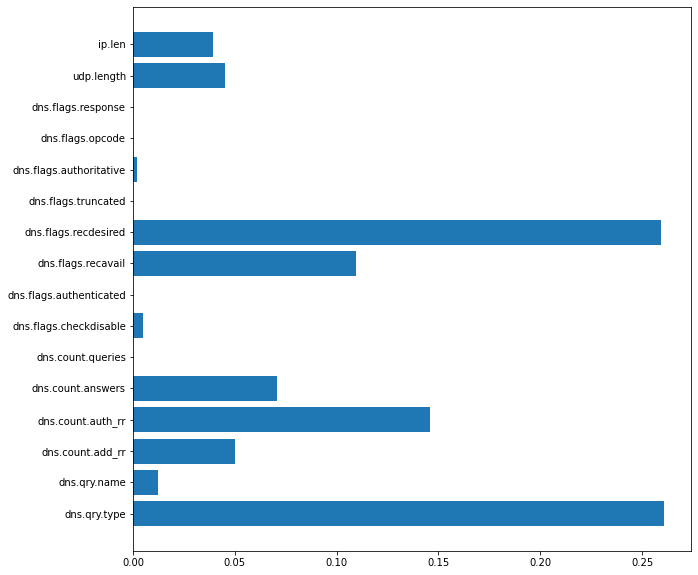

Client 2:
	Feature: ip.len, Score: 0.03346
	Feature: udp.length, Score: 0.03723
	Feature: dns.flags.response, Score: 0.00000
	Feature: dns.flags.opcode, Score: 0.00000
	Feature: dns.flags.authoritative, Score: 0.09467
	Feature: dns.flags.truncated, Score: 0.00000
	Feature: dns.flags.recdesired, Score: 0.22862
	Feature: dns.flags.recavail, Score: 0.04566
	Feature: dns.flags.authenticated, Score: 0.00000
	Feature: dns.flags.checkdisable, Score: 0.00293
	Feature: dns.count.queries, Score: 0.00000
	Feature: dns.count.answers, Score: 0.06983
	Feature: dns.count.auth_rr, Score: 0.15865
	Feature: dns.count.add_rr, Score: 0.01896
	Feature: dns.qry.name, Score: 0.01322
	Feature: dns.qry.type, Score: 0.29677



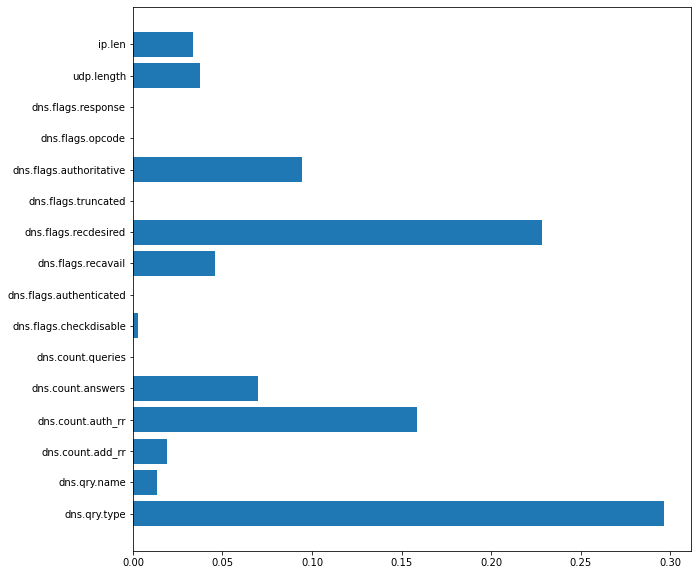

Client 3:
	Feature: ip.len, Score: 0.00833
	Feature: udp.length, Score: 0.00961
	Feature: dns.flags.response, Score: 0.00000
	Feature: dns.flags.opcode, Score: 0.00000
	Feature: dns.flags.authoritative, Score: 0.09360
	Feature: dns.flags.truncated, Score: 0.00002
	Feature: dns.flags.recdesired, Score: 0.25918
	Feature: dns.flags.recavail, Score: 0.14648
	Feature: dns.flags.authenticated, Score: 0.00000
	Feature: dns.flags.checkdisable, Score: 0.01462
	Feature: dns.count.queries, Score: 0.00000
	Feature: dns.count.answers, Score: 0.03711
	Feature: dns.count.auth_rr, Score: 0.03289
	Feature: dns.count.add_rr, Score: 0.01749
	Feature: dns.qry.name, Score: 0.08931
	Feature: dns.qry.type, Score: 0.29138



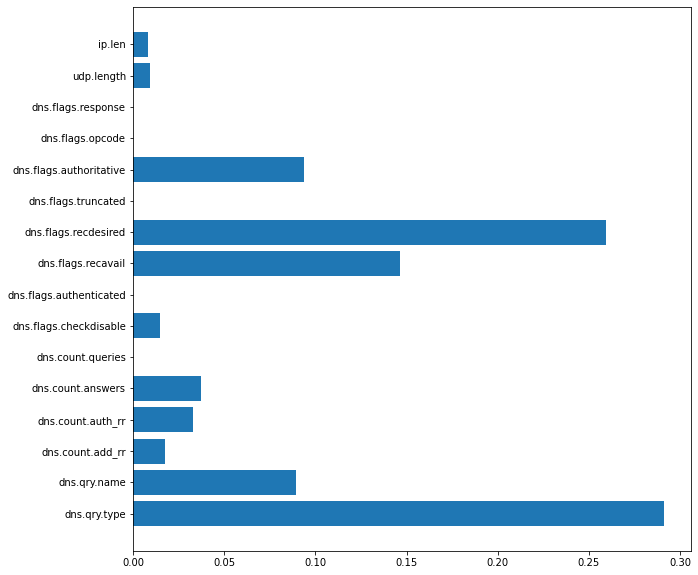

Client 4:
	Feature: ip.len, Score: 0.08559
	Feature: udp.length, Score: 0.11721
	Feature: dns.flags.response, Score: 0.00000
	Feature: dns.flags.opcode, Score: 0.00000
	Feature: dns.flags.authoritative, Score: 0.00514
	Feature: dns.flags.truncated, Score: 0.00054
	Feature: dns.flags.recdesired, Score: 0.31534
	Feature: dns.flags.recavail, Score: 0.18774
	Feature: dns.flags.authenticated, Score: 0.00000
	Feature: dns.flags.checkdisable, Score: 0.00005
	Feature: dns.count.queries, Score: 0.00000
	Feature: dns.count.answers, Score: 0.14634
	Feature: dns.count.auth_rr, Score: 0.01636
	Feature: dns.count.add_rr, Score: 0.00440
	Feature: dns.qry.name, Score: 0.09980
	Feature: dns.qry.type, Score: 0.02148



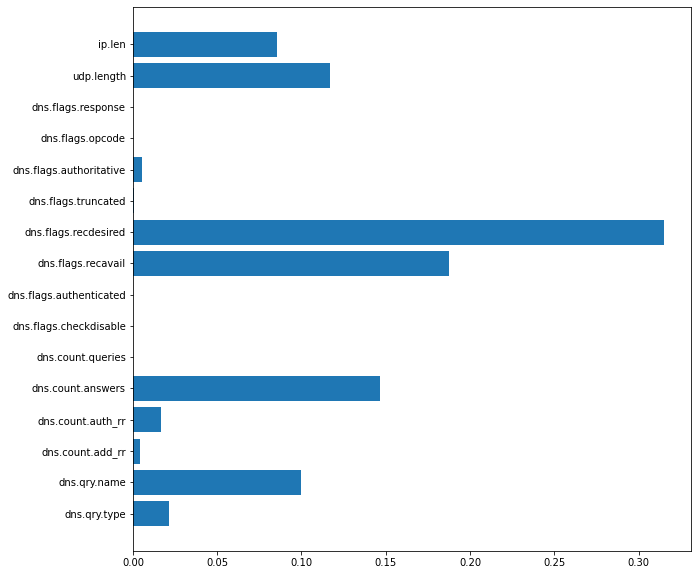

Client 5:
	Feature: ip.len, Score: 0.05800
	Feature: udp.length, Score: 0.06735
	Feature: dns.flags.response, Score: 0.00000
	Feature: dns.flags.opcode, Score: 0.00000
	Feature: dns.flags.authoritative, Score: 0.03669
	Feature: dns.flags.truncated, Score: 0.00007
	Feature: dns.flags.recdesired, Score: 0.32574
	Feature: dns.flags.recavail, Score: 0.19591
	Feature: dns.flags.authenticated, Score: 0.00000
	Feature: dns.flags.checkdisable, Score: 0.09624
	Feature: dns.count.queries, Score: 0.00000
	Feature: dns.count.answers, Score: 0.00273
	Feature: dns.count.auth_rr, Score: 0.02557
	Feature: dns.count.add_rr, Score: 0.01064
	Feature: dns.qry.name, Score: 0.16537
	Feature: dns.qry.type, Score: 0.01571



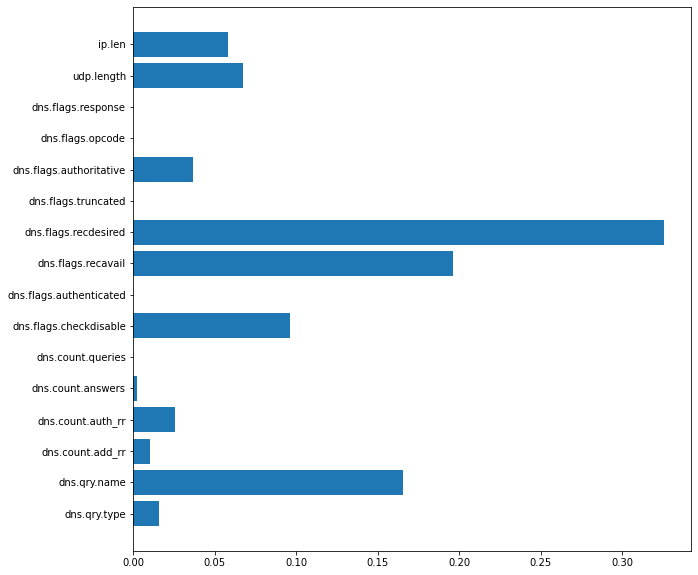

Client 6:
	Feature: ip.len, Score: 0.06925
	Feature: udp.length, Score: 0.10401
	Feature: dns.flags.response, Score: 0.00000
	Feature: dns.flags.opcode, Score: 0.00000
	Feature: dns.flags.authoritative, Score: 0.01369
	Feature: dns.flags.truncated, Score: 0.00013
	Feature: dns.flags.recdesired, Score: 0.24045
	Feature: dns.flags.recavail, Score: 0.17471
	Feature: dns.flags.authenticated, Score: 0.00000
	Feature: dns.flags.checkdisable, Score: 0.03607
	Feature: dns.count.queries, Score: 0.00000
	Feature: dns.count.answers, Score: 0.05849
	Feature: dns.count.auth_rr, Score: 0.00589
	Feature: dns.count.add_rr, Score: 0.00154
	Feature: dns.qry.name, Score: 0.00300
	Feature: dns.qry.type, Score: 0.29275



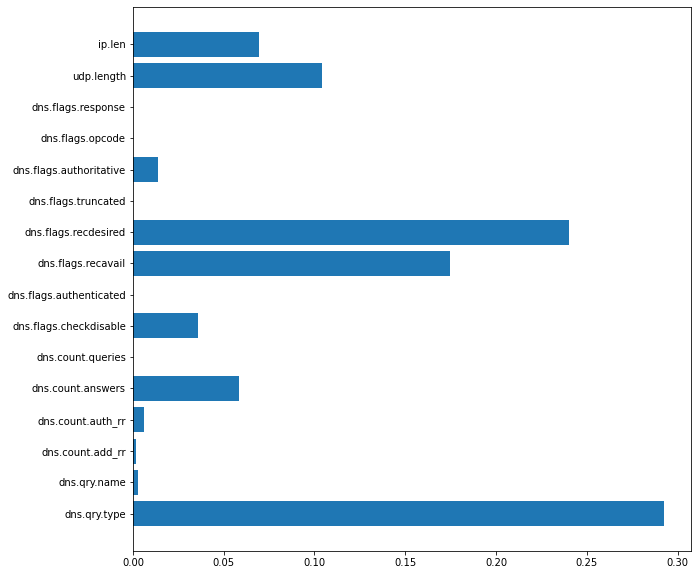

Client 7:
	Feature: ip.len, Score: 0.05751
	Feature: udp.length, Score: 0.06321
	Feature: dns.flags.response, Score: 0.00000
	Feature: dns.flags.opcode, Score: 0.00000
	Feature: dns.flags.authoritative, Score: 0.00758
	Feature: dns.flags.truncated, Score: 0.00000
	Feature: dns.flags.recdesired, Score: 0.24177
	Feature: dns.flags.recavail, Score: 0.18036
	Feature: dns.flags.authenticated, Score: 0.00000
	Feature: dns.flags.checkdisable, Score: 0.01858
	Feature: dns.count.queries, Score: 0.00000
	Feature: dns.count.answers, Score: 0.09802
	Feature: dns.count.auth_rr, Score: 0.00243
	Feature: dns.count.add_rr, Score: 0.00870
	Feature: dns.qry.name, Score: 0.03788
	Feature: dns.qry.type, Score: 0.28395



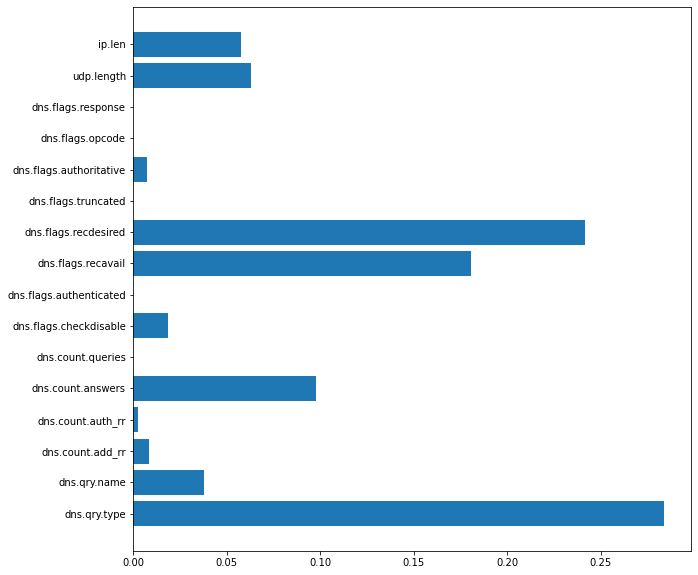

Client 8:
	Feature: ip.len, Score: 0.02832
	Feature: udp.length, Score: 0.04134
	Feature: dns.flags.response, Score: 0.00000
	Feature: dns.flags.opcode, Score: 0.00000
	Feature: dns.flags.authoritative, Score: 0.00185
	Feature: dns.flags.truncated, Score: 0.00007
	Feature: dns.flags.recdesired, Score: 0.21997
	Feature: dns.flags.recavail, Score: 0.10755
	Feature: dns.flags.authenticated, Score: 0.00000
	Feature: dns.flags.checkdisable, Score: 0.00468
	Feature: dns.count.queries, Score: 0.00000
	Feature: dns.count.answers, Score: 0.08128
	Feature: dns.count.auth_rr, Score: 0.16411
	Feature: dns.count.add_rr, Score: 0.04994
	Feature: dns.qry.name, Score: 0.01568
	Feature: dns.qry.type, Score: 0.28521



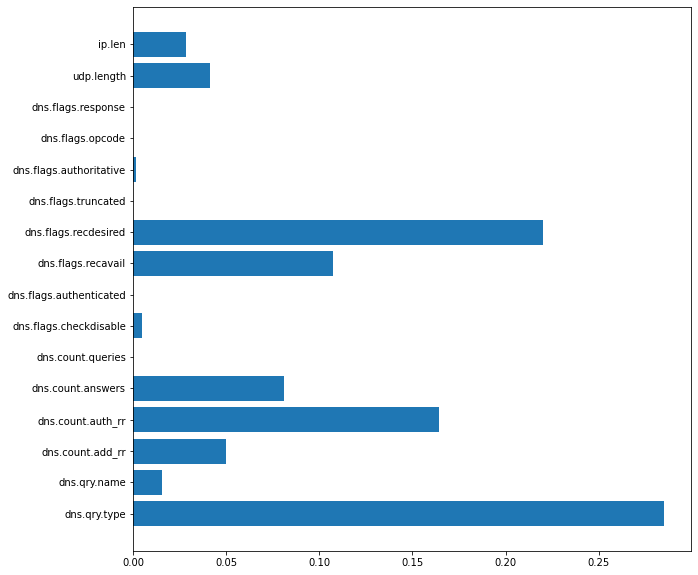

Client 9:
	Feature: ip.len, Score: 0.02977
	Feature: udp.length, Score: 0.02784
	Feature: dns.flags.response, Score: 0.00000
	Feature: dns.flags.opcode, Score: 0.00000
	Feature: dns.flags.authoritative, Score: 0.07038
	Feature: dns.flags.truncated, Score: 0.00000
	Feature: dns.flags.recdesired, Score: 0.20010
	Feature: dns.flags.recavail, Score: 0.03750
	Feature: dns.flags.authenticated, Score: 0.00000
	Feature: dns.flags.checkdisable, Score: 0.00338
	Feature: dns.count.queries, Score: 0.00000
	Feature: dns.count.answers, Score: 0.09896
	Feature: dns.count.auth_rr, Score: 0.14750
	Feature: dns.count.add_rr, Score: 0.03953
	Feature: dns.qry.name, Score: 0.01727
	Feature: dns.qry.type, Score: 0.32775



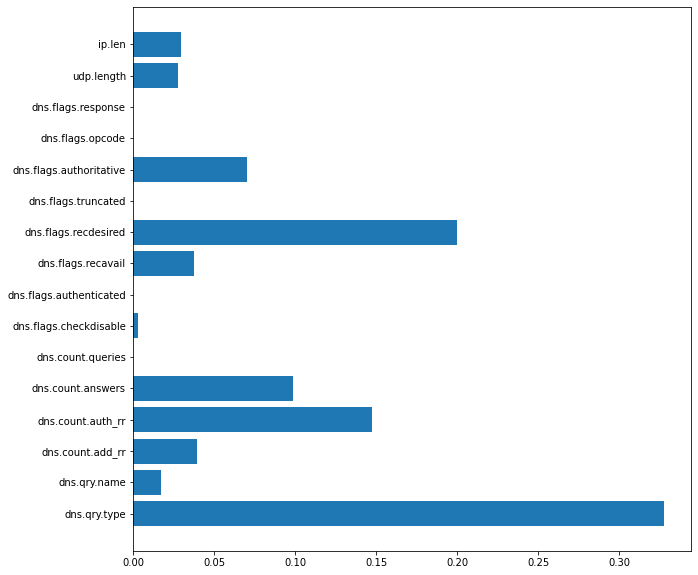

Client 10:
	Feature: ip.len, Score: 0.03002
	Feature: udp.length, Score: 0.02691
	Feature: dns.flags.response, Score: 0.00000
	Feature: dns.flags.opcode, Score: 0.00000
	Feature: dns.flags.authoritative, Score: 0.00158
	Feature: dns.flags.truncated, Score: 0.00152
	Feature: dns.flags.recdesired, Score: 0.23518
	Feature: dns.flags.recavail, Score: 0.12164
	Feature: dns.flags.authenticated, Score: 0.00015
	Feature: dns.flags.checkdisable, Score: 0.00003
	Feature: dns.count.queries, Score: 0.00000
	Feature: dns.count.answers, Score: 0.07513
	Feature: dns.count.auth_rr, Score: 0.04395
	Feature: dns.count.add_rr, Score: 0.01261
	Feature: dns.qry.name, Score: 0.19950
	Feature: dns.qry.type, Score: 0.25178



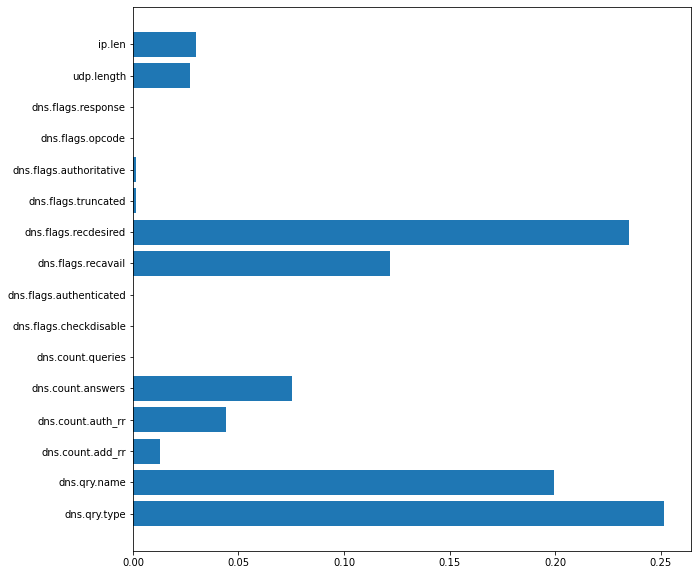

Client 11:
	Feature: ip.len, Score: 0.04432
	Feature: udp.length, Score: 0.04455
	Feature: dns.flags.response, Score: 0.00000
	Feature: dns.flags.opcode, Score: 0.00000
	Feature: dns.flags.authoritative, Score: 0.00232
	Feature: dns.flags.truncated, Score: 0.00067
	Feature: dns.flags.recdesired, Score: 0.29409
	Feature: dns.flags.recavail, Score: 0.11608
	Feature: dns.flags.authenticated, Score: 0.00000
	Feature: dns.flags.checkdisable, Score: 0.24193
	Feature: dns.count.queries, Score: 0.00000
	Feature: dns.count.answers, Score: 0.08086
	Feature: dns.count.auth_rr, Score: 0.13614
	Feature: dns.count.add_rr, Score: 0.00078
	Feature: dns.qry.name, Score: 0.01676
	Feature: dns.qry.type, Score: 0.02150



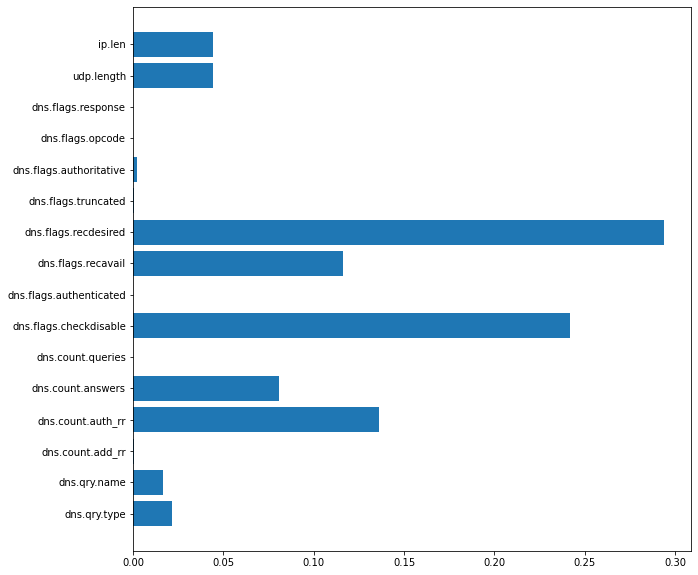

Client 12:
	Feature: ip.len, Score: 0.09784
	Feature: udp.length, Score: 0.09644
	Feature: dns.flags.response, Score: 0.00000
	Feature: dns.flags.opcode, Score: 0.00000
	Feature: dns.flags.authoritative, Score: 0.05711
	Feature: dns.flags.truncated, Score: 0.00009
	Feature: dns.flags.recdesired, Score: 0.18241
	Feature: dns.flags.recavail, Score: 0.15877
	Feature: dns.flags.authenticated, Score: 0.00000
	Feature: dns.flags.checkdisable, Score: 0.00098
	Feature: dns.count.queries, Score: 0.00000
	Feature: dns.count.answers, Score: 0.00287
	Feature: dns.count.auth_rr, Score: 0.05341
	Feature: dns.count.add_rr, Score: 0.02746
	Feature: dns.qry.name, Score: 0.31159
	Feature: dns.qry.type, Score: 0.01102



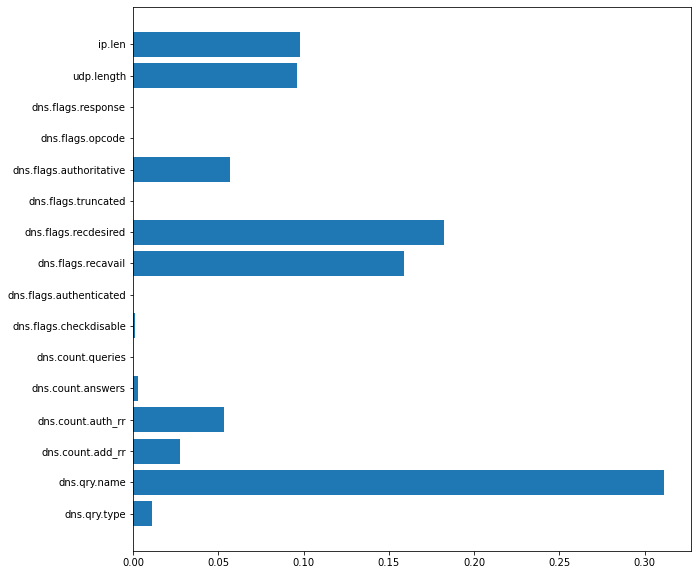

Client 13:
	Feature: ip.len, Score: 0.05155
	Feature: udp.length, Score: 0.09558
	Feature: dns.flags.response, Score: 0.00000
	Feature: dns.flags.opcode, Score: 0.00003
	Feature: dns.flags.authoritative, Score: 0.00612
	Feature: dns.flags.truncated, Score: 0.00389
	Feature: dns.flags.recdesired, Score: 0.19223
	Feature: dns.flags.recavail, Score: 0.14384
	Feature: dns.flags.authenticated, Score: 0.00000
	Feature: dns.flags.checkdisable, Score: 0.03192
	Feature: dns.count.queries, Score: 0.00000
	Feature: dns.count.answers, Score: 0.11204
	Feature: dns.count.auth_rr, Score: 0.00492
	Feature: dns.count.add_rr, Score: 0.01194
	Feature: dns.qry.name, Score: 0.01005
	Feature: dns.qry.type, Score: 0.33590



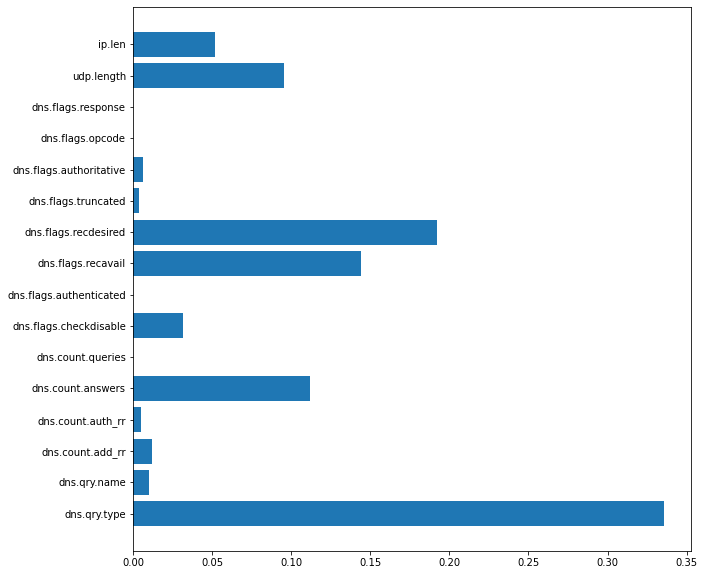

Client 14:
	Feature: ip.len, Score: 0.06526
	Feature: udp.length, Score: 0.07018
	Feature: dns.flags.response, Score: 0.00000
	Feature: dns.flags.opcode, Score: 0.00000
	Feature: dns.flags.authoritative, Score: 0.01977
	Feature: dns.flags.truncated, Score: 0.00003
	Feature: dns.flags.recdesired, Score: 0.17183
	Feature: dns.flags.recavail, Score: 0.24612
	Feature: dns.flags.authenticated, Score: 0.00000
	Feature: dns.flags.checkdisable, Score: 0.00636
	Feature: dns.count.queries, Score: 0.00000
	Feature: dns.count.answers, Score: 0.11006
	Feature: dns.count.auth_rr, Score: 0.00550
	Feature: dns.count.add_rr, Score: 0.00228
	Feature: dns.qry.name, Score: 0.03770
	Feature: dns.qry.type, Score: 0.26491



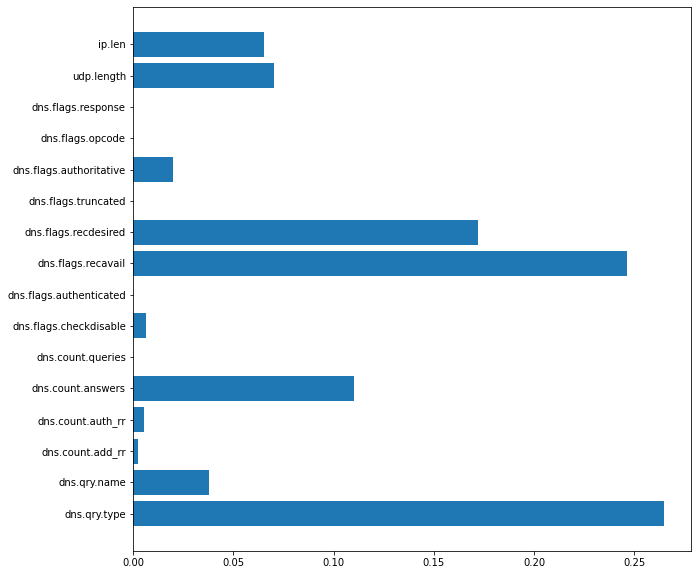

Client 15:
	Feature: ip.len, Score: 0.04994
	Feature: udp.length, Score: 0.06292
	Feature: dns.flags.response, Score: 0.00000
	Feature: dns.flags.opcode, Score: 0.00000
	Feature: dns.flags.authoritative, Score: 0.01183
	Feature: dns.flags.truncated, Score: 0.00000
	Feature: dns.flags.recdesired, Score: 0.21315
	Feature: dns.flags.recavail, Score: 0.11098
	Feature: dns.flags.authenticated, Score: 0.00000
	Feature: dns.flags.checkdisable, Score: 0.00038
	Feature: dns.count.queries, Score: 0.00000
	Feature: dns.count.answers, Score: 0.07333
	Feature: dns.count.auth_rr, Score: 0.14961
	Feature: dns.count.add_rr, Score: 0.02182
	Feature: dns.qry.name, Score: 0.00744
	Feature: dns.qry.type, Score: 0.29859



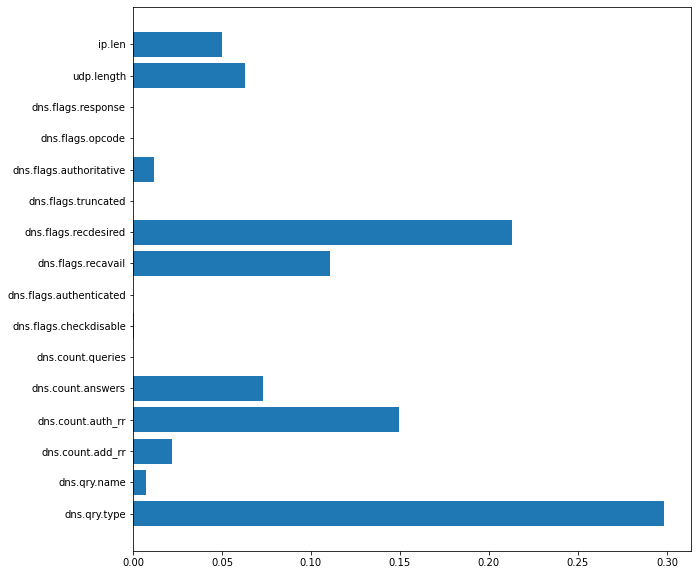

Client 16:
	Feature: ip.len, Score: 0.02685
	Feature: udp.length, Score: 0.02799
	Feature: dns.flags.response, Score: 0.00000
	Feature: dns.flags.opcode, Score: 0.00000
	Feature: dns.flags.authoritative, Score: 0.05551
	Feature: dns.flags.truncated, Score: 0.00000
	Feature: dns.flags.recdesired, Score: 0.26061
	Feature: dns.flags.recavail, Score: 0.06525
	Feature: dns.flags.authenticated, Score: 0.00000
	Feature: dns.flags.checkdisable, Score: 0.00004
	Feature: dns.count.queries, Score: 0.00000
	Feature: dns.count.answers, Score: 0.09215
	Feature: dns.count.auth_rr, Score: 0.14347
	Feature: dns.count.add_rr, Score: 0.02436
	Feature: dns.qry.name, Score: 0.01128
	Feature: dns.qry.type, Score: 0.29248



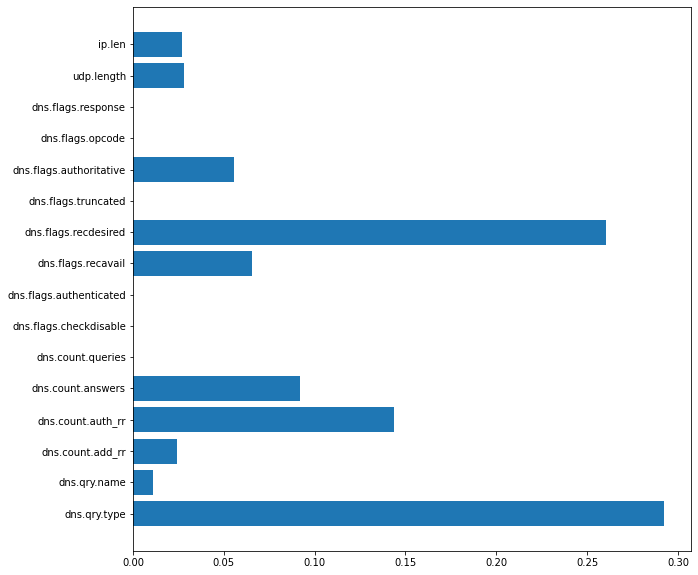

Client 17:
	Feature: ip.len, Score: 0.02973
	Feature: udp.length, Score: 0.03860
	Feature: dns.flags.response, Score: 0.00000
	Feature: dns.flags.opcode, Score: 0.00000
	Feature: dns.flags.authoritative, Score: 0.01169
	Feature: dns.flags.truncated, Score: 0.00000
	Feature: dns.flags.recdesired, Score: 0.24189
	Feature: dns.flags.recavail, Score: 0.17220
	Feature: dns.flags.authenticated, Score: 0.00000
	Feature: dns.flags.checkdisable, Score: 0.00336
	Feature: dns.count.queries, Score: 0.00000
	Feature: dns.count.answers, Score: 0.06695
	Feature: dns.count.auth_rr, Score: 0.06733
	Feature: dns.count.add_rr, Score: 0.02005
	Feature: dns.qry.name, Score: 0.02223
	Feature: dns.qry.type, Score: 0.32598



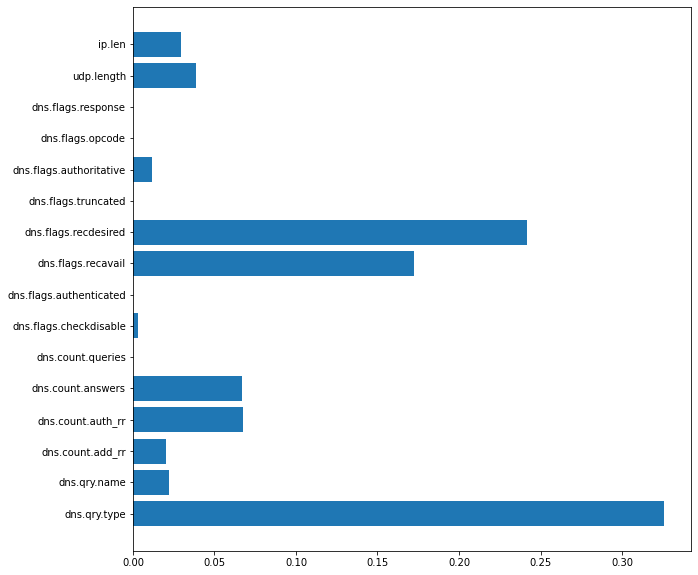

Client 18:
	Feature: ip.len, Score: 0.08659
	Feature: udp.length, Score: 0.08215
	Feature: dns.flags.response, Score: 0.00000
	Feature: dns.flags.opcode, Score: 0.00000
	Feature: dns.flags.authoritative, Score: 0.00578
	Feature: dns.flags.truncated, Score: 0.00046
	Feature: dns.flags.recdesired, Score: 0.30133
	Feature: dns.flags.recavail, Score: 0.14728
	Feature: dns.flags.authenticated, Score: 0.00001
	Feature: dns.flags.checkdisable, Score: 0.02302
	Feature: dns.count.queries, Score: 0.00000
	Feature: dns.count.answers, Score: 0.09716
	Feature: dns.count.auth_rr, Score: 0.20678
	Feature: dns.count.add_rr, Score: 0.00190
	Feature: dns.qry.name, Score: 0.01391
	Feature: dns.qry.type, Score: 0.03362



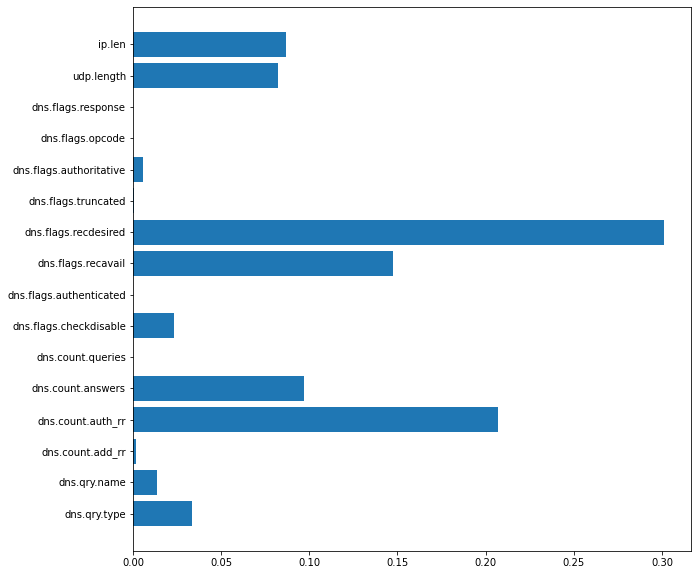

Client 19:
	Feature: ip.len, Score: 0.14356
	Feature: udp.length, Score: 0.19184
	Feature: dns.flags.response, Score: 0.00000
	Feature: dns.flags.opcode, Score: 0.00000
	Feature: dns.flags.authoritative, Score: 0.00511
	Feature: dns.flags.truncated, Score: 0.00040
	Feature: dns.flags.recdesired, Score: 0.29355
	Feature: dns.flags.recavail, Score: 0.10908
	Feature: dns.flags.authenticated, Score: 0.00016
	Feature: dns.flags.checkdisable, Score: 0.00208
	Feature: dns.count.queries, Score: 0.00000
	Feature: dns.count.answers, Score: 0.01813
	Feature: dns.count.auth_rr, Score: 0.09792
	Feature: dns.count.add_rr, Score: 0.01662
	Feature: dns.qry.name, Score: 0.07115
	Feature: dns.qry.type, Score: 0.05039



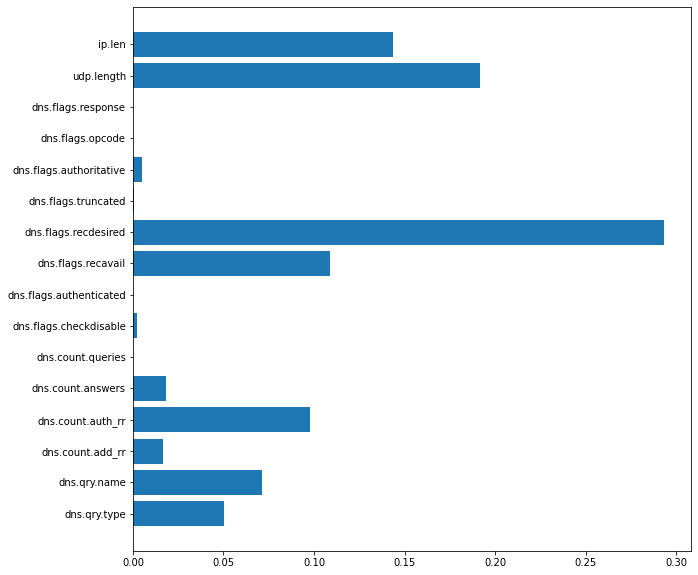

Client 20:
	Feature: ip.len, Score: 0.04943
	Feature: udp.length, Score: 0.06781
	Feature: dns.flags.response, Score: 0.00000
	Feature: dns.flags.opcode, Score: 0.00000
	Feature: dns.flags.authoritative, Score: 0.00375
	Feature: dns.flags.truncated, Score: 0.00270
	Feature: dns.flags.recdesired, Score: 0.22290
	Feature: dns.flags.recavail, Score: 0.18808
	Feature: dns.flags.authenticated, Score: 0.00001
	Feature: dns.flags.checkdisable, Score: 0.00134
	Feature: dns.count.queries, Score: 0.00000
	Feature: dns.count.answers, Score: 0.11215
	Feature: dns.count.auth_rr, Score: 0.03134
	Feature: dns.count.add_rr, Score: 0.01264
	Feature: dns.qry.name, Score: 0.00398
	Feature: dns.qry.type, Score: 0.30387



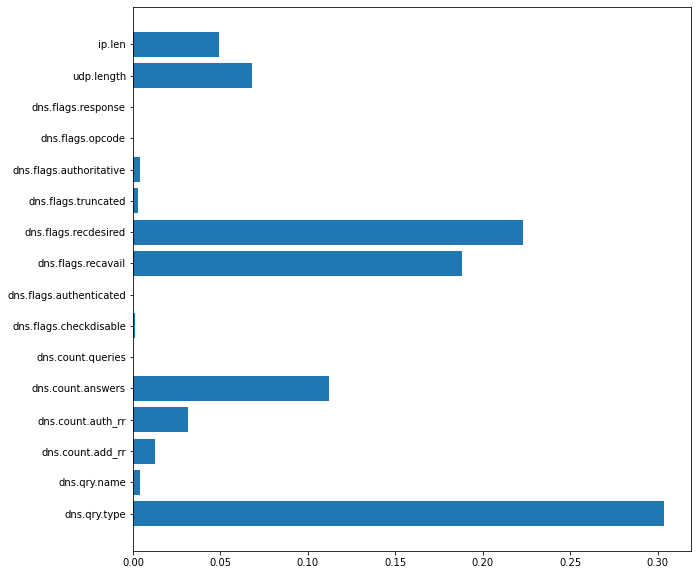

Client 21:
	Feature: ip.len, Score: 0.06479
	Feature: udp.length, Score: 0.07121
	Feature: dns.flags.response, Score: 0.00000
	Feature: dns.flags.opcode, Score: 0.00000
	Feature: dns.flags.authoritative, Score: 0.00387
	Feature: dns.flags.truncated, Score: 0.00016
	Feature: dns.flags.recdesired, Score: 0.27802
	Feature: dns.flags.recavail, Score: 0.16481
	Feature: dns.flags.authenticated, Score: 0.00000
	Feature: dns.flags.checkdisable, Score: 0.04663
	Feature: dns.count.queries, Score: 0.00000
	Feature: dns.count.answers, Score: 0.09180
	Feature: dns.count.auth_rr, Score: 0.00501
	Feature: dns.count.add_rr, Score: 0.02090
	Feature: dns.qry.name, Score: 0.01360
	Feature: dns.qry.type, Score: 0.23920



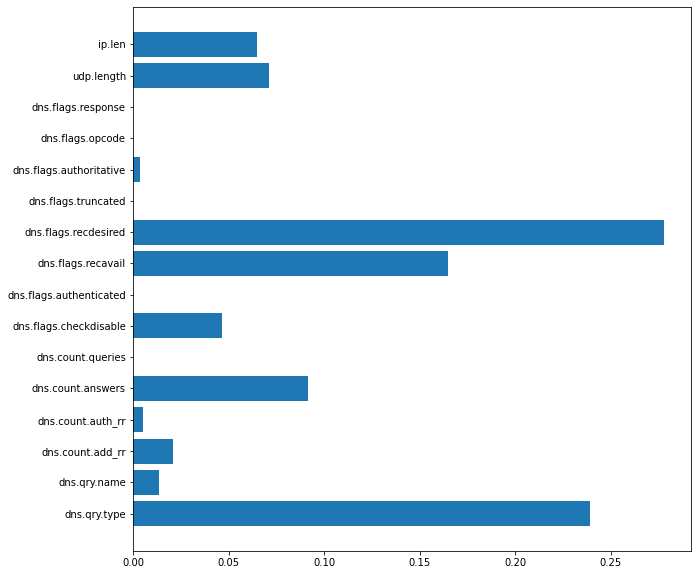

In [ ]:
rfc = RandomForestClassifier()
importance = [[] for i in clients_datasets]
for i in range(0, 21):
    importance[i] = [0 for j in clients_datasets[i].columns[:-1]]
    for n in range(0, 10):
        rfc.fit(clients_datasets[i].iloc[:,:-1], clients_datasets[i].iloc[:,-1])
        importance[i] += rfc.feature_importances_

    importance[i] /= 10
    # summarize feature importance
    print('Client ' + str(i+1) + ':')
    for j, v in enumerate(importance[i]):
        print('\tFeature: %s, Score: %.5f' % (clients_datasets[i].columns[j],v))
    print()
    # plot feature importance
    fig, ax = plt.subplots(figsize=(10,10))
    ax.barh(clients_datasets[i].columns[:-1], importance[i])
    ax.invert_yaxis()
    plt.show()

Clients drop the features that they found less important. Each client drops features with importance score less than 0.01.

In [ ]:
for i in range(0, 21):
    initial_columns = clients_datasets[i].columns
    for j in range(len(importance[i])):
        if importance[i][j] < 0.01:
            clients_datasets[i].drop(columns=initial_columns[j], inplace=True)
clients_datasets[0].columns

Index(['ip.len', 'udp.length', 'dns.flags.recdesired', 'dns.flags.recavail',
       'dns.count.answers', 'dns.count.auth_rr', 'dns.count.add_rr',
       'dns.qry.name', 'dns.qry.type', 'target'],
      dtype='object')

Each client privately normalizes its data. Scalers are then send to the central entity and the aggregated scaler is used to normalize the test set. Every client only contributes to the features that has chosen after feature selection step.

In [ ]:
scaler = StandardScaler()
scaling_results = []
for i in range(0, 21):
    clients_datasets[i].iloc[:,:-1] = scaler.fit_transform(clients_datasets[i].iloc[:,:-1])
    # each client sends a dictionary with keys being features names
    # and values being tuples of mean and standard deviation of features 
    scaling_results.append(dict(zip(clients_datasets[i].columns[:-1], zip(scaler.mean_, scaler.scale_))))

In [ ]:
clients_datasets[0].head()

,ip.len,udp.length,dns.flags.recdesired,dns.flags.recavail,dns.count.answers,dns.count.auth_rr,dns.count.add_rr,dns.qry.name,dns.qry.type,target
23559,0.143427,-0.002555,-1.0,-0.904879,-0.888242,-0.542406,-0.931547,0.980116,-1.003299,0.0
42406,0.347414,0.150348,1.0,1.105120,0.804111,0.987655,1.143167,0.279151,0.998132,1.0
7677,-0.643381,-0.592320,-1.0,-0.904879,-0.888242,-0.542406,-0.931547,-1.305442,-1.003299,0.0
34827,-0.553309,-0.524805,-1.0,-0.904879,-0.888242,-0.542406,-0.931547,1.788754,-1.003299,0.0
28147,-0.977179,-0.842524,-1.0,-0.904879,-0.627880,-1.853888,-0.931547,1.306022,-0.871517,0.0


In [ ]:
scaling_results[0]

{'dns.count.add_rr': (10.878002040422423, 10.603873337634916),
 'dns.count.answers': (6.823131221220393, 7.6816105599784485),
 'dns.count.auth_rr': (8.481498331816804, 4.574979985993746),
 'dns.flags.recavail': (0.4501888769404693, 0.4975126651850667),
 'dns.flags.recdesired': (0.5, 0.5),
 'dns.qry.name': (55983193.42734442, 21410640.36794614),
 'dns.qry.type': (133.81365980092096, 121.41316023309797),
 'ip.len': (764.8599691179309, 377.4743234620235),
 'udp.length': (800.2864725508038, 503.5898025446306)}

For each feature, aggregated scaler's mean will be the sum of this feature's means of clients weighted by each client's dataset size. Likewise, for each feature, aggregated scaler's standard deviation will be the maximum value of the standard deviations of this feature among all clients.

Test set has to be scaled appropriately depending on the number of clients that will be used in each case.

In [ ]:
testing_sets = []
for n in [7, 14, 21]:
    # total number of packets for n clients, needed for the weighted means
    total_samples = 0
    for i in range(0, 21):
        total_samples += len(clients_datasets[i])

    # initialize scaler and dictionaries
    scaler.fit(testset.iloc[:,:-1])
    scaler.mean_ = []
    scaler.scale_ = []
    means = {i:0 for i in testset.columns[:-1]}
    sds = {i:-1 for i in testset.columns[:-1]}

    # compute appropriate mean and standard deviation values
    for i in range(0, n):
        for j, v in scaling_results[i].items():
            means[j] += v[0]*len(clients_datasets[i])/total_samples
            if v[1] > sds[j]:
                sds[j] = v[1]

    # if sds[i] = -1, feature i is dropped at all clients (since standard deviation can never be negative)
    # assign sds[i] = 1, which together with means[i] = 0, leads to not scaling feature i
    for i in sds:
        if sds[i] == -1:
            sds[i] = 1

    # pass values to the scaler
    for i in testset.columns[:-1]:
        scaler.mean_.append(means[i])
        scaler.scale_.append(sds[i])

    # scale test set
    testing_sets.append(pd.DataFrame(testset.values, columns=testset.columns))
    testing_sets[n//7-1].iloc[:,:-1] = scaler.transform(testset.iloc[:,:-1])

In [ ]:
print(scaler.mean_)
print(scaler.scale_)

[674.8834560316086, 1128.1016317965039, 0, 0, 0.165974064718257, 0, 0.506602998888693, 0.47052883452187144, 0, 0.16336520993861156, 0, 46.18426706020331, 3.442460386620027, 4.262507330115601, 48888185.984435804, 95.91788655851586]
[692.7837268665598, 1989.1042404937248, 1, 1, 0.4938441879138052, 1, 0.5, 0.4999947410915245, 1, 0.49999999541846335, 1, 125.3489786131167, 155.7653253628959, 10.844381785988586, 28154002.0962621, 134.60166786587772]


In [ ]:
testing_sets[2].head()

,ip.len,udp.length,dns.flags.response,dns.flags.opcode,dns.flags.authoritative,dns.flags.truncated,dns.flags.recdesired,dns.flags.recavail,dns.flags.authenticated,dns.flags.checkdisable,dns.count.queries,dns.count.answers,dns.count.auth_rr,dns.count.add_rr,dns.qry.name,dns.qry.type,target
0,-0.477614,-0.404253,1.0,0.0,-0.336086,0.0,-1.013206,-0.941068,0.0,-0.32673,1.0,-0.368446,0.003579,-0.300848,0.890929,-0.623454,0.0
1,-0.865903,-0.539490,1.0,0.0,-0.336086,0.0,-1.013206,-0.941068,0.0,1.67327,1.0,-0.368446,-0.022100,-0.300848,-0.301463,-0.504584,0.0
2,0.547237,-0.047309,1.0,0.0,-0.336086,0.0,0.986794,1.058953,0.0,-0.32673,1.0,-0.256757,0.061359,1.727853,0.464297,1.181873,1.0
3,1.191016,1.487051,1.0,0.0,-0.336086,1.0,0.986794,1.058953,0.0,-0.32673,1.0,1.641942,-0.022100,-0.300848,0.770297,-0.705176,1.0
4,-0.863016,-0.538484,1.0,0.0,1.688844,1.0,-1.013206,-0.941068,0.0,1.67327,1.0,-0.368446,-0.022100,-0.300848,0.104085,-0.705176,0.0


**Note:** Some features of the test set are indeed not scaled, because all clients happened to have dropped these features. The code is general, taking into account that there could be a client who would keep a feature that others have dropped. This will also be taken into account in the learning process, where the central model's weights will all be initialized to zero, so that unused features do not affect the testing performed by the central entity.

Write all datasets.

In [ ]:
for i in range(0, 21):
    clients_datasets[i].to_csv('client' + str(i+1) + '.csv', index=False)
for i in [7, 14, 21]:
    testing_sets[i//7-1].to_csv('test' + str(i) + '.csv', index=False)